In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, TimeDistributed
from keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy as scipy
from keras.callbacks import TensorBoard
from keras.regularizers import l1, activity_l1
from keras.regularizers import l2, activity_l2
from sklearn import preprocessing  
from datetime import datetime

Using TensorFlow backend.


In [3]:
numpy.random.seed(7)

In [4]:
df_train = pd.read_csv("../train.csv")
df_test = pd.read_csv("../test.csv")

In [5]:
df_train['month'] = pd.DatetimeIndex(df_train.datetime).month
df_train['day'] = pd.DatetimeIndex(df_train.datetime).dayofweek
df_train['hour'] = pd.DatetimeIndex(df_train.datetime).hour
df_train['year'] = pd.DatetimeIndex(df_train.datetime).year

In [6]:
df_train_train = df_train.drop(['datetime','casual','registered','count'], axis = 1)
#df_train_train = df_train_train.drop(['season','workingday','weather','holiday'], axis = 1)
df_test_train = df_train['count']

In [7]:
df_train_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,day,hour,year
0,1,0,0,1,9.84,14.395,81,0,1,5,0,2011
1,1,0,0,1,9.02,13.635,80,0,1,5,1,2011
2,1,0,0,1,9.02,13.635,80,0,1,5,2,2011
3,1,0,0,1,9.84,14.395,75,0,1,5,3,2011
4,1,0,0,1,9.84,14.395,75,0,1,5,4,2011


In [25]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df_test_train.values.astype('float32').reshape(-1,1))
timesteps = 1
def preprocess_nn(datax,datay):
    train_X_n = preprocessing.scale(datax.values.astype('float32'))
    train_Y_n = scaler.transform(datay.values.astype('float32').reshape(-1,1))
    n = len(train_X_n)
    train_x = train_X_n[0:int(n*.8)].astype('float32')
    train_y = train_Y_n[0:int(n*.8)].astype('float32')
    test_x = train_X_n[int(n*.8)+1:n].astype('float32')
    test_y = train_Y_n[int(n*.8)+1:n].astype('float32')
    return train_x, train_y, test_x, test_y
def preshape_nn(data_x):
    data_x = numpy.reshape(data_x, (data_x.shape[0]/timesteps, timesteps, data_x.shape[1]))
    return data_x
def learn_nn(train_x, train_y, test_x, test_y):
    from keras.models import Sequential
    from keras.layers import LSTM, Dense
    import numpy as np

    data_dim = len(train_x[0])

    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    #model.add(Dense(100))
    model.add(LSTM(100, return_sequences=True,
                   input_shape=(timesteps, data_dim) )) #W_regularizer=l2(0.01) 
    model.add(LSTM(100, return_sequences=True)) #, W_regularizer=l2(0.01)
    model.add(LSTM(10))  
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error',
                  optimizer='rmsprop')


    x_train = preshape_nn(train_x)
    y_train = train_y #scaler.transform(train_y)


    x_val = preshape_nn(test_x)
    y_val = test_y#scaler.transform(test_y)
    # generate dummy validation data

    now = datetime.now()

    model.fit(x_train, y_train,
              batch_size=100, nb_epoch=100,
              validation_data=(x_val, y_val),callbacks=[TensorBoard(log_dir='logs/' + now.strftime("%Y%m%d-%H%M%S") + "/")])
    return model

In [9]:
pre1 = preprocess_nn(df_train_train,df_test_train)
m1 = learn_nn(pre1[0],pre1[1],pre1[2],pre1[3])

Train on 8708 samples, validate on 2177 samples
Epoch 1/100
8708/8708 [==============================] - 6s - loss: 0.1667 - val_loss: 0.1405
Epoch 2/100
8708/8708 [==============================] - 6s - loss: 0.0615 - val_loss: 0.1222
Epoch 3/100
8708/8708 [==============================] - 8s - loss: 0.0550 - val_loss: 0.1094
Epoch 4/100
8708/8708 [==============================] - 8s - loss: 0.0508 - val_loss: 0.1084
Epoch 5/100
8708/8708 [==============================] - 9s - loss: 0.0484 - val_loss: 0.1035
Epoch 6/100
8708/8708 [==============================] - 7s - loss: 0.0456 - val_loss: 0.0957
Epoch 7/100
8708/8708 [==============================] - 7s - loss: 0.0429 - val_loss: 0.0914
Epoch 8/100
8708/8708 [==============================] - 7s - loss: 0.0413 - val_loss: 0.0866
Epoch 9/100
8708/8708 [==============================] - 7s - loss: 0.0397 - val_loss: 0.0880
Epoch 10/100
8708/8708 [==============================] - 10s - loss: 0.0389 - val_loss: 0.0838
Epoch 11/1

/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


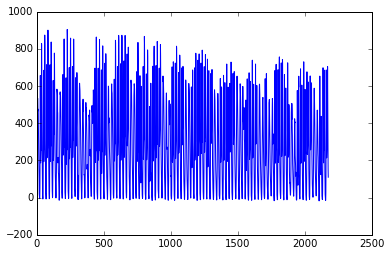

In [28]:
plt.plot(scaler.inverse_transform(m1.predict(preshape_nn(pre1[2]))))

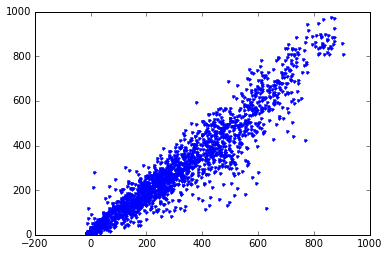

In [29]:
plt.plot(scaler.inverse_transform(m1.predict(preshape_nn(pre1[2]))),scaler.inverse_transform(pre1[3]),'.')

In [33]:
df_test['month'] = pd.DatetimeIndex(df_test.datetime).month
df_test['day'] = pd.DatetimeIndex(df_test.datetime).dayofweek
df_test['hour'] = pd.DatetimeIndex(df_test.datetime).hour
df_test['year'] = pd.DatetimeIndex(df_test.datetime).year
df_test_test = df_test.drop(['datetime'], axis = 1)
#df_test_test = df_test_test.drop(['season','workingday','weather','holiday'], axis = 1)
df_test_t = preprocessing.scale(df_test_test.values)
df_test_r = preshape_nn(df_test_t)
pred = m1.predict(df_test_r)
out = scaler.inverse_transform(pred).astype(int)
out[out<0] = 0
out = out[:,0]
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': out})
pred = pred[['datetime','count']]
pred.to_csv("pred.csv", index = False)

In [32]:
pred

array([[-1.0078789 ],
       [-1.01546395],
       [-1.02477872],
       ..., 
       [-0.70951605],
       [-0.81182176],
       [-0.90357906]], dtype=float32)

In [ ]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_val)
train_y_r_e = np.exp(train_y)
trainPredict = np.exp(scaler.inverse_transform(trainPredict))
test_y_r_e = np.exp(test_y)
testPredict = np.exp(scaler.inverse_transform(testPredict))

In [ ]:
trainScore = math.sqrt(mean_squared_error(train_y_r_e, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y_r_e, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
print scipy.stats.pearsonr(train_y_r_e,trainPredict[:,0])[0]
plt.plot(train_y_r_e,trainPredict,'.')

In [ ]:
plt.plot(train_y_r_e-trainPredict[:,0])

In [ ]:
print scipy.stats.pearsonr(test_y_r_e,testPredict[:,0])[0]
plt.plot(test_y_r_e,testPredict,'.')

In [ ]:
df_test['month'] = pd.DatetimeIndex(df_test.datetime).month
df_test['day'] = pd.DatetimeIndex(df_test.datetime).dayofweek
df_test['hour'] = pd.DatetimeIndex(df_test.datetime).hour
df_test['year'] = pd.DatetimeIndex(df_test.datetime).year
df_test_test = df_test.drop(['datetime'], axis = 1)
#df_test_test = df_test_test.drop(['season','workingday','weather','holiday'], axis = 1)
df_test_t = preprocessing.scale(df_test_test.values)
df_test_r = numpy.reshape(df_test_t, (df_test_t.shape[0], timesteps , df_test_t.shape[1]))
pred = model.predict(df_test_r)

In [ ]:
out = np.exp(scaler.inverse_transform(pred)).astype(int)
out[out<0] = 0
out = out[:,0]

In [ ]:
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': out})
pred = pred[['datetime','count']]

In [ ]:
pred.to_csv("pred.csv", index = False)

In [ ]:
predicted = pd.read_csv('pred.csv')

In [ ]:
plt.plot(predicted['count'])

In [ ]:
plt.hist(predicted['count'])

In [ ]:
plt.plot(df_train['count'].values)

In [ ]:
plt.plot(predicted['count'][500:1000])

In [ ]:
a= []
for i in range(10):
    b = df_train['datetime'][i <= pd.DatetimeIndex(df_train['datetime']).dayofyear < 9*(i+1)].values
    a.append(b)
print a

In [ ]:
a[1]

In [ ]:
df_train['datetime'][0:24*10-7][25:24+24]

In [ ]:
x_train = np.random.random((1000, 8, 3))


In [ ]:
x_train[0]

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

data_dim = 16
timesteps = 8
nb_classes = 10

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()

model.add(LSTM(100, return_sequences=True,
               input_shape=(timesteps, data_dim) )) #W_regularizer=l2(0.01) 
model.add(LSTM(100, return_sequences=True)) #, W_regularizer=l2(0.01)
model.add(LSTM(100))  
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='rmsprop')

# generate dummy training data
x_train = np.random.random((1000, timesteps, data_dim))
y_train = 10*np.random.random((1000))

# generate dummy validation data
x_val = np.random.random((100, timesteps, data_dim))
y_val = np.random.random((100))

now = datetime.now()

model.fit(x_train, y_train,
          batch_size=64, nb_epoch=100,
          validation_data=(x_val, y_val),
          callbacks=[TensorBoard(log_dir='logs1/' + now.strftime("%Y%m%d-%H%M%S") + "/")])